# Introduction to supervised learning (part II)

Recall, that in order to be able to make changes in this colaboratory you need to do **(File -> Save a copy in Drive)**. <br>
[**Homework #1**](https://colab.research.google.com/drive/1Tm5oVf8HI6ACEzoKorm1hmVTnzq-dTaV) associated with this practice session is linked on the homework's page, the deadline is **September 18, Sunday, midnight (23:59 EET time)**

## NYC Taxi dataset
Here we will work with real-world dataset collected from taxis operating in New York City

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':'1XKhfq4WFHlTrvag48cD3VDJGfykYUJ-s'}) 
downloaded.GetContentFile('nyc_data_2.zip')

In [ ]:
# check that nyc_data_2.zip exists
!ls

nyc_data_2.zip	sample_data


In [ ]:
# After archive has been downloaded
# unzip it
!unzip nyc_data_2.zip

# check that train_2M.csv, test.csv, model.pickle and sample_submission.csv exist
!ls

Archive:  nyc_data_2.zip
  inflating: train_2M.csv            
  inflating: test.csv                
  inflating: model.pickle            
  inflating: sample_submission.csv   
model.pickle	sample_data	       test.csv
nyc_data_2.zip	sample_submission.csv  train_2M.csv


* `train_2M.csv` contains 2 million observations from NYC dataset (6 independent variables and fare_amount that we need to predict).
* `test.csv` contains new observations, for which we have to estimate `fare_amount` based on train data.
* `sample_submission.csv` - a sample submission file in the correct format (columns `key` and `fare_amount`). Every row in this file matches every row in `test.csv`.
* `model.pickle` - file that contains trained model saved as a pickle (we are going to deal with it later)

### Setting up Kaggle

You need to have an account on Kaggle.com, before you proceed. When you access your kaggle profile, you need to download your API Token from kaggle. It's very easy:
1. Click on your profile icon
2. Go to **Account**
3. In **API** you press **Create new API token**

Now we load the file **kaggle.json** that you have downloaded, into this notebook:

In [ ]:
from google.colab import files

files.upload(); # upload your kaggle.json file

Saving kaggle.json to kaggle.json


The next cell moves the file into a separate folder, sets secure access for it and configures your Kaggle profile for this notebook.

In [ ]:
import json

!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In order to sign up for a NYC Taxi competition you need to accept the rules by cliking on "Late submission" button in the upper right corner: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction

Make a test submission to ensure that the submission mechanism works

In [ ]:
!kaggle competitions submit -c new-york-city-taxi-fare-prediction -f sample_submission.csv -m "Sample submission test"

100% 335k/335k [00:00<00:00, 831kB/s]
Successfully submitted to New York City Taxi Fare Prediction

Now you can check `My submissions` tab on the website: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/submissions

## Read in the NYC data

In [ ]:
import numpy as np 
import pandas as pd
 
# note that we use only 1M out of 2M records
train =  pd.read_csv('train_2M.csv', parse_dates=["pickup_datetime"], nrows = 1000000) # the first row will automatically be interpreted as a header

## Brief Exploratory Data Analysis (EDA)

In [ ]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


In [ ]:
train.dtypes

fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

In [ ]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.000000,1000000.000000,1000000.000000,999990.000000,999990.000000,1000000.000000
mean,11.348079,-72.526640,39.929008,-72.527860,39.919954,1.684924
std,9.822090,12.057937,7.626154,11.324494,8.201418,1.323911
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


In [ ]:
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(train)

In [ ]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754


Read in test set

In [ ]:
test = pd.read_csv('test.csv')
test.dtypes

key                   object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [ ]:
add_travel_vector_features(test)

In [ ]:
print(train.isnull().sum())

fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude     10
dropoff_latitude      10
passenger_count        0
abs_diff_longitude    10
abs_diff_latitude     10
dtype: int64


In [ ]:
print(f'Old size: {len(train)}')
train = train.dropna(how = 'any', axis = 'rows')
print(f'New size: {len(train)}')

Old size: 1000000
New size: 999990


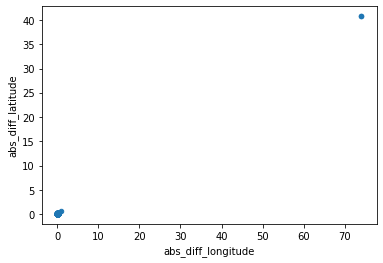

In [ ]:
plot = train.iloc[:2000].plot.scatter('abs_diff_longitude', 'abs_diff_latitude')

In [ ]:
print(f'Old size: {len(train)}')
train = train[(train.abs_diff_longitude < 5.0) & (train.abs_diff_latitude < 5.0)]
print(f'New size: {len(train)}')

Old size: 999990
New size: 998025


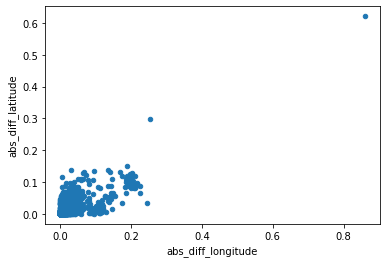

In [ ]:
plot = train.iloc[:2000].plot.scatter('abs_diff_longitude', 'abs_diff_latitude')

### Naive baseline
**Classroom exercise**: what is a reasonable baseline for predicting fare amount (`fare_amount` column in NYC taxi dataset) without knowing anything else?

In [ ]:
##### YOUR CODE STARTS #####
baseline_predictions = train.fare_amount.mean()
##### YOUR CODE ENDS ##### 

In [ ]:
baseline_predictions

11.341214398436914

In [ ]:
# Write the predictions to a CSV file which we can submit to the competition.
submission = pd.DataFrame(
    {'key': test.key, 'fare_amount': baseline_predictions},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission_baseline.csv', index = False)

!ls

model.pickle	sample_data	       submission_baseline.csv	train_2M.csv
nyc_data_2.zip	sample_submission.csv  test.csv


**Classroom exercise**: submit `submission_baseline.csv` to kaggle using earlier example, report RMSE that you get

In [ ]:
##### YOUR CODE STARTS #####
!kaggle competitions submit -c new-york-city-taxi-fare-prediction -f submission_baseline.csv -m "Baseline submission test"
##### YOUR CODE ENDS ##### (please do not delete this line)

100% 461k/461k [00:00<00:00, 1.31MB/s]
Successfully submitted to New York City Taxi Fare Prediction

### Linear regression on NYC taxi dataset based on one feature (abs_diff_longitude)

**Classroom exercise**: Use earlier example on 2D data to calculate **`slope`** (`w1`) and **`intercept`** based on **`abs_diff_longitude`**


Lets recall that we have an exact solution for the parameters of linear regression $\hat{y} = \omega_{1} x + \omega_{0}$ that minimizes mean squared error: <br>
MSE = $\frac{1}{N}\sum_{i=1}^{N}(y_{i}-\hat{y}_{i})^{2}$, <br>
where $N$ is a number of samples, $y_{i}$ - true value. 
$$\omega_{1} = \frac{\sum_{i=1}^{n}{(x_{i} - \bar{x})(y_{i} - \bar{y})}}{\sum_{i=1}^{n}{(x_{i} - \bar{x})^{2}}}$$
$$\text{intercept}=\bar{y}-\omega_{1}\bar{x},$$
where $\bar{x}$ and $\bar{y}$ are the mean values of $\textbf{x}$ and $\textbf{y}$ vectors correspondingly.

In [ ]:
##### YOUR CODE STARTS #####
x = train.abs_diff_longitude
y = train.fare_amount

w1 = (np.sum((x-np.mean(x))*(y-np.mean(y))))/np.sum((x-np.mean(x))**2)
intercept = np.mean(y) - w1*np.mean(x)
##### YOUR CODE ENDS ##### (please do not delete this line)
print(f"w1 = {round(w1, 8)}; intercept = {round(intercept, 8)}")

w1 = 179.08616006; intercept = 7.31070345


Instead of calculating coefficients ourselves, we can use sklearn

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(train[['abs_diff_longitude']], train[['fare_amount']])

LinearRegression()

#### Inspecting model object

In [ ]:
dir(lr)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_decision_function',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_preprocess_data',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_residues',
 '_set_intercept',
 '_validate_data',
 'coef_',
 'copy_X',
 'feature_names_in_',
 'fit',
 'fit_intercept',
 'get_params',
 'intercept_',
 'n_features_in_',
 'n_jobs',
 'normalize',
 'positive',
 'predict',
 'rank_',
 'score',
 'set_params',
 'singular_']

In [ ]:
# Print learnt weights
print(f'[{round(lr.coef_[0][0], 8)}, {round(lr.intercept_[0], 8)}]')

[179.08616006, 7.31070345]


Using earlier example, let's predict `fare_amount` based on calculated coefficients **`intercept`** and **`w1`** and **`test.abs_diff_longitude`**.

In [ ]:
predictions_manual = w1*test.abs_diff_longitude + intercept

Here is how you can predict `fare_amount` for `test` using sklearn object `lr`:

In [ ]:
predictions_sklearn = lr.predict(test[['abs_diff_longitude']])

In [ ]:
submission = pd.DataFrame(
    {'key': test.key, 'fare_amount': np.squeeze(predictions_sklearn)},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission_lr_2d.csv', index = False)

!ls 

model.pickle	sample_data	       submission_baseline.csv	test.csv
nyc_data_2.zip	sample_submission.csv  submission_lr_2d.csv	train_2M.csv


In [ ]:
!kaggle competitions submit -c new-york-city-taxi-fare-prediction -f submission_lr_2d.csv -m "Linear Regression with only abs_diff_longitude as an independent variable"

100% 454k/454k [00:00<00:00, 1.14MB/s]
Successfully submitted to New York City Taxi Fare Prediction

In [ ]:
!head submission_lr_2d.csv

key,fare_amount
2015-01-27 13:08:24.0000002,8.763100513241412
2015-01-27 13:08:24.0000003,9.464022144954694
2011-10-08 11:53:44.0000002,7.824680727296262
2012-12-01 21:12:12.0000002,8.974055702575013
2012-12-01 21:12:12.0000003,11.343544686356646
2012-12-01 21:12:12.0000005,10.568997044091063
2011-10-06 12:10:20.0000001,9.210628520017995
2011-10-06 12:10:20.0000003,44.52498659500914
2011-10-06 12:10:20.0000002,10.712086885978357


What RMSE you obtained with this model?

## Save/load model using pickle.

In [ ]:
import pickle
import os

pickle.dump(lr, open('linear_regression.pickle', 'wb'))

if os.path.getsize('linear_regression.pickle') > 0:  
    print("file is not empty")

file is not empty


In [ ]:
!ls

linear_regression.pickle  sample_data		   submission_lr_2d.csv
model.pickle		  sample_submission.csv    test.csv
nyc_data_2.zip		  submission_baseline.csv  train_2M.csv


In [ ]:
del lr

Now, if you call `lr` you should get an error:

In [ ]:
lr

NameError: ignored

In [ ]:
filename = 'linear_regression.pickle'
with open(filename, 'rb') as file:
  lr = pickle.load(file)

Check that `lr` object has been loaded successfully


In [ ]:
lr

LinearRegression()

In [ ]:
print(f'[{round(lr.coef_[0][0], 8)}, {round(lr.intercept_[0], 8)}]')

[179.08616006, 7.31070345]


### Linear regression based on more than one feature

In [ ]:
lr = LinearRegression()
lr.fit(train[['abs_diff_longitude', 'abs_diff_latitude']], train[['fare_amount']])

# Print learnt weights
print(f'[{round(lr.coef_[0][0], 8)}, {round(lr.coef_[0][1], 8)} , {round(lr.intercept_[0], 8)}]')

[146.1216904, 89.26772999 , 6.17039106]


Predict `fare_amount` for test set and submit predictions to kaggle

In [ ]:
# Predict fare_amount on the test set using our model (w) trained on the training set.
test_y_predictions = lr.predict(test[['abs_diff_longitude', 'abs_diff_latitude']])

# Write the predictions to a CSV file which we can submit to the competition.
submission = pd.DataFrame(
    {'key': test.key, 'fare_amount': np.squeeze(test_y_predictions)},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission_lr_3d.csv', index = False)

!ls 

linear_regression.pickle  sample_submission.csv    test.csv
model.pickle		  submission_baseline.csv  train_2M.csv
nyc_data_2.zip		  submission_lr_2d.csv
sample_data		  submission_lr_3d.csv


In [ ]:
!kaggle competitions submit -c new-york-city-taxi-fare-prediction -f submission_lr_3d.csv -m "Linear Regression with two predictors on 1M records"

100% 454k/454k [00:00<00:00, 881kB/s]
Successfully submitted to New York City Taxi Fare Prediction

### Decision Tree (DT)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dtr= DecisionTreeRegressor(max_depth = 100)
dtr.fit(train[['abs_diff_longitude', 'abs_diff_latitude']], train[['fare_amount']])

DecisionTreeRegressor(max_depth=100)

How can we predict the goodness of this model without sending it to the server? (Hint: remember RMSE?)

In [ ]:
np.sqrt(np.mean((dtr.predict(train[['abs_diff_longitude', 'abs_diff_latitude']]) - train['fare_amount'])**2))

2.598579835411356

or using built-in function:

In [ ]:
from sklearn.metrics import mean_squared_error
# squared = False returns RMSE, otherwise MSE
mean_squared_error(train.fare_amount, dtr.predict(train[['abs_diff_longitude', 'abs_diff_latitude']]), squared = False)

2.598579835411356

Very good! What would be our standing in the leaderboard if this RMSE was true?

Let's now submit this mode's predictions to kaggle and compare RMSE scores

In [ ]:
test_y_predictions = dtr.predict(test[['abs_diff_longitude', 'abs_diff_latitude']])

In [ ]:
# Write the predictions to a CSV file which we can submit to the competition.
submission = pd.DataFrame(
    {'key': test.key, 'fare_amount': test_y_predictions},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission_dt.csv', index = False)

!kaggle competitions submit -c new-york-city-taxi-fare-prediction -f submission_dt.csv -m "Decision Tree Regressor using 1M records and max_depth = 100"

100% 322k/322k [00:00<00:00, 546kB/s]
Successfully submitted to New York City Taxi Fare Prediction

### Train, val split for more accurate estimate of our model performance
We will divide our initial `train` into `train_X` (80%) and `val_X`(20%). We shall create separate variables `train_y` and `val_y` that will hold fare_amount for corresponding rows for convenience.

In [ ]:
train_X = train[0:int(len(train)*0.8)]
train_y = train.fare_amount[0:int(len(train)*0.8)]

**Classroom exercise**: assign remaining 20% of the data to val_X, val_y

In [ ]:
##### YOUR CODE STARTS #####
val_X = train[int(len(train)*0.8):]
val_y = train.fare_amount[int(len(train)*0.8):]
##### YOUR CODE ENDS ##### (please do not delete this line)

In [ ]:
print(train_X.shape)
print(train_y.shape)
print(val_X.shape)
print(val_y.shape)

(798420, 9)
(798420,)
(199605, 9)
(199605,)


In [ ]:
train_X[0:5]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754


What if your first samples were easier to predict than the later ones?

In [ ]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(train, np.array(train['fare_amount']), 
                                                      random_state = 111, 
                                                      test_size = 0.20) # you can also explicitely say how many observations will be in the validation set

In [ ]:
print(train_X.shape)
print(train_y.shape)
print(val_X.shape)
print(val_y.shape)

(798420, 9)
(798420,)
(199605, 9)
(199605,)


In [ ]:
train_X[0:5]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude
532805,34.3,2012-03-25 00:48:00,-73.991870,40.725952,-73.921162,40.880293,1,0.070708,0.154341
568773,4.9,2009-10-05 16:52:00,-74.008297,40.737962,-74.003597,40.748382,1,0.004700,0.010420
295336,4.5,2014-04-27 19:31:00,-73.986800,40.750375,-73.987827,40.755322,2,0.001027,0.004947
828760,8.5,2013-01-06 00:50:00,-74.002555,40.739702,-73.986750,40.764188,5,0.015805,0.024486
731917,8.5,2009-01-05 09:13:50,-73.966283,40.764822,-73.946407,40.793230,1,0.019876,0.028408


We can train our models on training data and evaluating them on validation set to obtain more realistic estimates of RMSE. Let's see if this works with our decision tree model.

In [ ]:
dtr=DecisionTreeRegressor(max_depth = 100) 
dtr.fit(train_X[['abs_diff_longitude', 'abs_diff_latitude']], train_y)

DecisionTreeRegressor(max_depth=100)

In [ ]:
mean_squared_error(train_y, dtr.predict(train_X[['abs_diff_longitude', 'abs_diff_latitude']]), squared=False)

2.5138894597895542

In [ ]:
mean_squared_error(val_y, dtr.predict(val_X[['abs_diff_longitude', 'abs_diff_latitude']]), squared=False)

6.649117754130024

if you increase the depth of the decision tree (e.g. to 100), you will see that the gap between validation and train RMSE also grows. **What could be the reason?**

Now train a new decision tree instance on the whole dataset (train + validation sets combined) with a reasonable `max_depth`.

In [ ]:
dtr=DecisionTreeRegressor(max_depth = 10) 
dtr.fit(train[['abs_diff_longitude', 'abs_diff_latitude']], train[['fare_amount']])

DecisionTreeRegressor(max_depth=10)

In [ ]:
test_y_predictions = dtr.predict(test[['abs_diff_longitude', 'abs_diff_latitude']])

# Write the predictions to a CSV file which we can submit to the competition.
submission = pd.DataFrame(
    {'key': test.key, 'fare_amount': test_y_predictions},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission_dt.csv', index = False)

!ls

linear_regression.pickle  sample_submission.csv    submission_lr_3d.csv
model.pickle		  submission_baseline.csv  test.csv
nyc_data_2.zip		  submission_dt.csv	   train_2M.csv
sample_data		  submission_lr_2d.csv


In [ ]:
!kaggle competitions submit -c new-york-city-taxi-fare-prediction -f submission_dt.csv -m "Decision Tree Regressor using 1M records and max_depth = 10"

100% 454k/454k [00:00<00:00, 1.11MB/s]
Successfully submitted to New York City Taxi Fare Prediction